# Etude de la condition d'existence du Hawkes en environnement aléatoire

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

Ici, l'objectif est d'approcher des environnements où l'esperance du log est nulle (ou négative)

In [36]:
# Paramètres de l'environnement de simulation :
n = 10000
Lambda_init = 1
Tmax = 100
burn = 10
dt = (Tmax+burn)/n
mu = 1
theta = 0.7
sigma = 0.5
X_0 = 2
#poiss = np.unique(np.concatenate((np.arange(0, 0.81, 0.1), np.arange(0.8, 1.11, 0.01))))
poiss = np.unique(np.concatenate((np.arange(0.3, 0.81, 0.1), np.arange(0.8, 1.05, 0.01))))
n_env = 100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


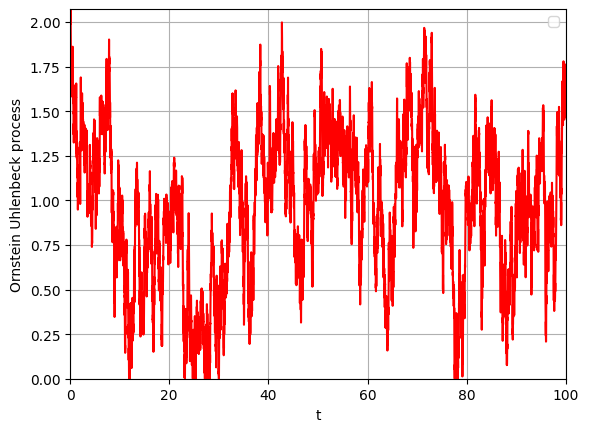

In [37]:
def rand_env(n, dt, mu, theta, sigma, X_0):
    X = np.zeros(n+1)
    X[0] = X_0
    for i in range(1,n+1):
        X[i] = X[i-1] + theta*(mu - X[i-1])*dt + sigma*np.random.normal(0,math.sqrt(dt))
        if X[i] < 0:
            X[i] = 0
    return X
X = rand_env(n, dt, mu, theta, sigma, X_0)
plot = plt.plot(np.linspace(0, Tmax, len(X)),X, color='red')
plt.xlim(0,Tmax)
plt.ylim(0,max(X))
plt.xlabel('t')
plt.ylabel('Ornstein Uhlenbeck process')
plt.legend()
plt.grid(True)

On a le nouveau critère a vérifier, 

In [38]:
#remove the values of X between 0 and 10
X = X[10:]

def critere(X, dt, Tmax):
    #define a vector taking values of exp(-t) between 0 and Tmax
    t = np.linspace(-Tmax, 0, len(X))
    exp_t = np.exp(t)
    return sum(X*exp_t)*dt
I = critere(X, dt, Tmax)

In [39]:
#MC method to estimate the expectation of the logarithm of the criterion, approx 2 min
def MC_esp(n_MC, n, dt, mu, theta, sigma, X_0, Tmax, burn):
    crit = 0
    for i in range(n_MC):
        X = rand_env(n, dt, mu, theta, sigma, X_0)
        X = X[burn:]
        crit += sum(X)/n
    return crit/n_MC

val = MC_esp(5000, n, dt, mu, theta, sigma, X_0, Tmax, burn)
val

1.0199590223856763

In [40]:
#MC method to estimate the expectation of the logarithm of the criterion, approx 2 min
def MC_log(n_MC, n, dt, mu, theta, sigma, X_0, Tmax, burn):
    crit = 0
    for i in range(n_MC):
        X = rand_env(n, dt, mu, theta, sigma, X_0)
        X = X[burn:]
        crit += math.log(critere(X, dt, Tmax))
    return crit/n_MC

val = MC_log(5000, n, dt, mu, theta, sigma, X_0, Tmax, burn)
val

0.046924159695617404

Pour différents environnements, pour différents alphas, on fait K itérations. On regarde ensuite le comportement du nombre d'evenements en fonction du lambda, pour essayer de voir le passage vers un état sur-critique.

In [41]:
# We define a function that returns the environment for a given time t using linear interpolation
def env(X,t):
    return X[int(t/dt)] + (X[int(t/dt)+1] - X[int(t/dt)])*(t/dt - int(t/dt))

In [42]:
def hawkes_process(Lambda_init, Tmax, norm, X):
    immigrants = np.random.poisson(Lambda_init * Tmax)
    hawkes = np.sort(np.random.uniform(0, Tmax, immigrants))
    #print("Nombre d'immigrants : " + str(immigrants))
    times = hawkes
    i = 1
    #time_steps = np.linspace(0, Tmax -10, 11)
    #step = 20
    print("norm : " + str(norm) )
    while len(times) != 0 :
        # print("pop : " + str(len(hawkes)))
        # We first get the number of childs for each individual
        num_childs = [np.random.poisson((norm)*env(X, root)) for root in times]
        # print("Nombre d'individus de la génération " + str(i) + " : " + str(len(times)))
        # end condition
        if(num_childs == [0]*len(times)):
            break
        
        # We remove individuals without childs
        times = [times[i] for i in range(len(times)) if num_childs[i] > 0]
        num_childs = [num_childs[i] for i in range(len(num_childs)) if num_childs[i] > 0]
        
        # We then create the next generation time vector
        next_gen_times = []
        for j in range(len(times)):
            for _ in range(num_childs[j]):
                next_gen_times.append(times[j] + np.random.exponential(norm))

        times = [val for val in next_gen_times if val < Tmax]
        
        # We finally update the Hawkes vector 
        hawkes = np.append(hawkes, times)
        if len(hawkes) > 1e6:
            print("stop the count, size = " + str(len(hawkes)))
            last_min = min(next_gen_times)
            return np.sort(hawkes[hawkes < last_min])
        i = i+1
    return np.sort(hawkes)

In [43]:
n_iter = 10
n_env = 200
non_explo = np.zeros(len(poiss))
perc = 0
hawkes_list = [[[[] for _ in range(n_iter)] for _ in range(len(poiss))] for _ in range(n_env)]
for k in range(n_env):
    X = rand_env(n, dt, mu, theta, sigma, X_0)
    X = X[burn:]
    for j in range(n_iter):
        for i in range(len(poiss)):
            perc += 1
            hawkes_result = hawkes_process(Lambda_init, Tmax, poiss[i], X)
            hawkes_list[k][i][j] = hawkes_result
            print("Iteration " + str(perc/(n_env*n_iter*len(poiss))*100) + "% done, last pop size = "+str(len(hawkes_list[k][i][j]))  )


norm : 0.3
Iteration 0.0016129032258064516% done, last pop size = 140
norm : 0.4
Iteration 0.0032258064516129032% done, last pop size = 237
norm : 0.5
Iteration 0.004838709677419355% done, last pop size = 260
norm : 0.6000000000000001
Iteration 0.0064516129032258064% done, last pop size = 181
norm : 0.7000000000000002
Iteration 0.008064516129032258% done, last pop size = 389
norm : 0.8
Iteration 0.00967741935483871% done, last pop size = 811
norm : 0.8000000000000003
Iteration 0.01129032258064516% done, last pop size = 389
norm : 0.81
Iteration 0.012903225806451613% done, last pop size = 912
norm : 0.8200000000000001
Iteration 0.014516129032258063% done, last pop size = 896
norm : 0.8300000000000001
Iteration 0.016129032258064516% done, last pop size = 895
norm : 0.8400000000000001
Iteration 0.017741935483870968% done, last pop size = 415
norm : 0.8500000000000001
Iteration 0.01935483870967742% done, last pop size = 2350
norm : 0.8600000000000001
Iteration 0.020967741935483872% done, l

Pour un lambda fixé, on va chercher a plot l'évolution du log du nombre d'évènements, et faire apparaître la moyenne. On va prendre la valeur tout les k pas de temps

Text(0.5, 1.0, 'log-Number of events for criterion = 0.09735285131163166')

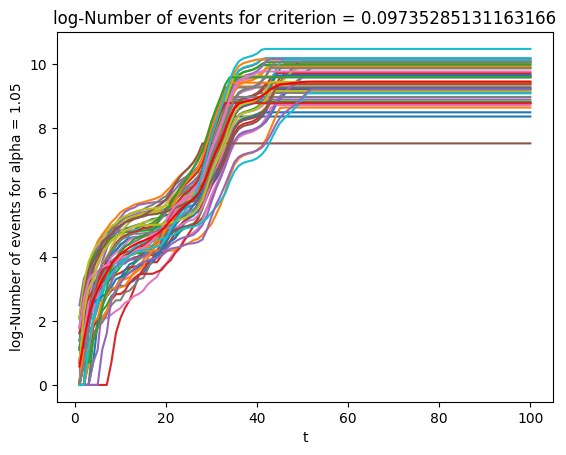

In [20]:
num_poiss = 21

time_step = np.unique(np.arange(1, Tmax + 1, 1))
choix = hawkes_list[0][num_poiss]
evt = [[math.log(max(len(choix[j][choix[j] < t]),1)) for t in time_step] for j in range(n_iter)]
for iter in evt:
    plt.plot(time_step, iter)
    # plt.plot(time_step[time_step < max(choix[iter])], evt[iter])
plt.plot(time_step, np.mean(evt, axis = 0), color = 'red')
#plt.plot(time_step, time_step, color = 'green')
plt.xlabel('t')
plt.ylabel('log-Number of events for alpha = ' + str(poiss[num_poiss]))
plt.title("log-Number of events for criterion = " + str(val + math.log(poiss[num_poiss])) ) 

In [27]:
[max(choix[j][i] for j in range(len(poiss)))]

[15.584508851131282]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


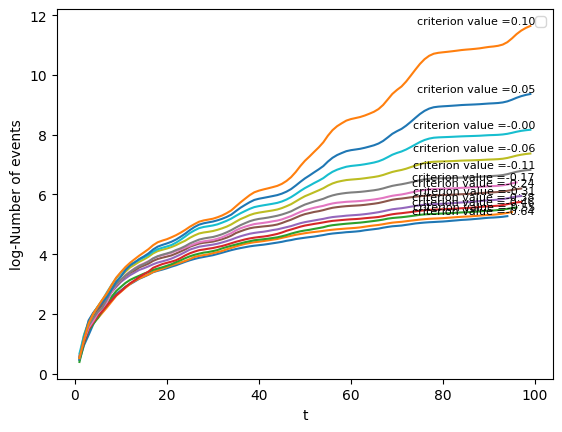

In [35]:
hawkes_env = hawkes_list[8]

for iter in range(10,len(poiss)):
    choix = hawkes_env[iter]
    max_T = min([max(choix[i]) for i in range(n_iter)]) 
    temp_N = [[math.log(max(len(choix[j][choix[j] < min(t, max_T)]),1)) for t in time_step[time_step < max_T]] for j in range(n_iter)]
    mean_temp_N = np.mean(temp_N, axis=0)
    
    # Plotting the curve
    plt.plot(time_step[time_step < max_T], mean_temp_N)
    
    #add the corresponding value of poiss for each plot
    plt.text(time_step[-1], mean_temp_N[-1], f'criterion value ={val + math.log(max(poiss[iter], .05)):.2f}', fontsize=8, verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('t')
plt.ylabel('log-Number of events')
plt.legend()
plt.show()